# Over the Hills

Example histograms with Formula 1 data from
https://ergast.com/mrd/db

In [1]:
%autosave 0

Autosave disabled


In [2]:
from etl import DATADIR, ErgastF1
from viz import Plot

In [3]:
f1 = ErgastF1(DATADIR / 'ergast/f1.zip')
plot = Plot()

## How old was each driver on each podium?

In [4]:
# Get podium finishes, driver names, and driver birthdays.
# Calculate age of each driver during each race.
pods = (
    f1.results[['id_driver', 'id_race', 'order']]
    .loc[lambda x: x['order'] <= 3]
    .join(f1.drivers[['driver', 'birthday']], on='id_driver')
    .join(f1.races['date'], on='id_race')
    .assign(age = lambda df: df['date'] - df['birthday'])
)
# If co-drivers share a result, then keep the older one.
pods = (
    pods[['date', 'order', 'driver', 'age']]
    .sort_values(['date', 'order', 'age'])
    .drop_duplicates(['date', 'order'], keep='last')
    .reset_index(drop=True)    
)
# Convert units for easier reading.
pods['age'] = (pods['age'].dt.days / 365.25).round(3)
# Show results.
print("{} rows x {} cols".format(*pods.shape))
pods.head()

3054 rows x 4 cols


,date,order,driver,age
0,1950-05-13,1,Nino Farina,43.535
1,1950-05-13,2,Luigi Fagioli,51.923
2,1950-05-13,3,Reg Parnell,38.864
3,1950-05-21,1,Juan Fangio,38.908
4,1950-05-21,2,Alberto Ascari,31.855


## golden years (and silver, bronze)

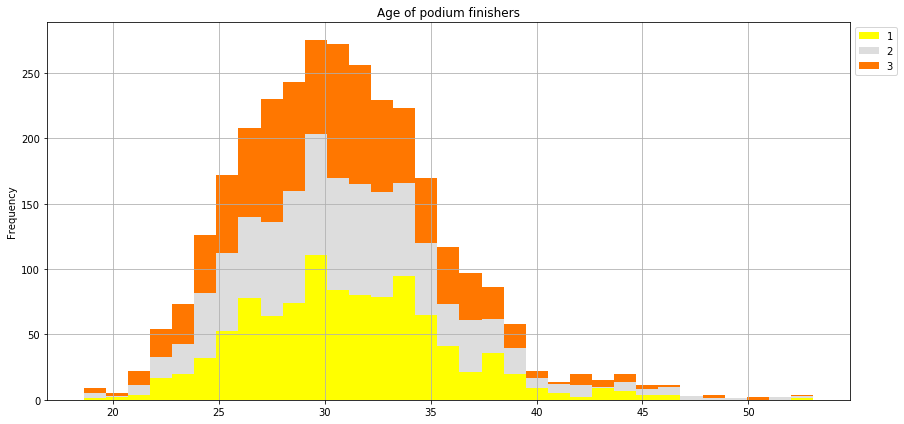

In [5]:
kw = dict()
kw['color'] = ['#ffff00', '#dddddd', '#ff7700']
kw['title'] = f"Age of podium finishers"
data = pods.pivot(index='date', columns='order', values='age')
axes = plot.hist(data, **kw)

## Are podium finishers getting younger?

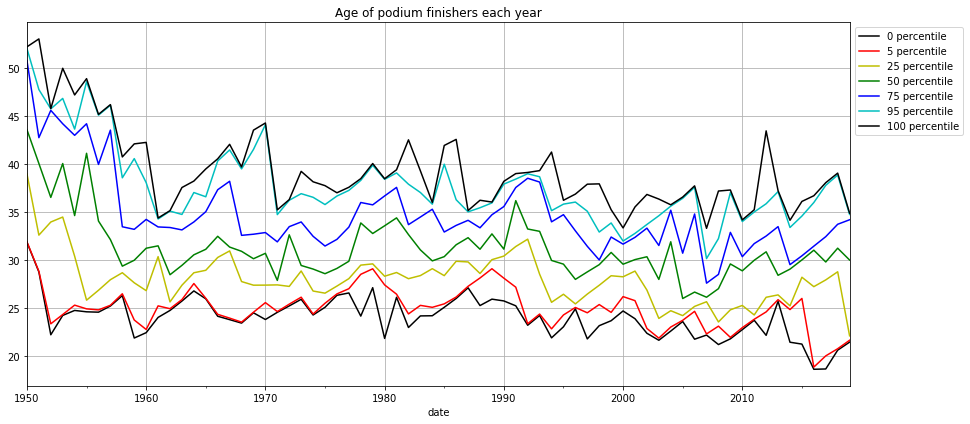

In [6]:
kw = dict()
kw['title'] = 'Age of podium finishers each year'
plot.quant(pods.set_index('date')['age'], 'y', **kw)

### inspect outliers

In [7]:
print("Oldest podium finishers")
olds = pods.groupby('driver')['age'].idxmax()
pods.loc[olds].nlargest(10, 'age').reset_index(drop=True)

Oldest podium finishers


,date,order,driver,age
0,1951-07-01,1,Luigi Fagioli,53.057
1,1950-05-21,3,Louis Chiron,50.795
2,1953-06-07,3,Felice Bonetto,49.996
3,1955-09-11,2,Piero Taruffi,48.914
4,1955-06-05,3,Nino Farina,48.597
5,1957-09-08,2,Juan Fangio,46.209
6,1955-07-16,3,Karl Kling,44.830
7,1950-06-18,3,Louis Rosier,44.616
8,1953-09-13,3,Luigi Villoresi,44.329
9,1970-07-18,2,Jack Brabham,44.293


In [8]:
print("Youngest podium finishers")
utes = pods.groupby('driver')['age'].idxmin()
pods.loc[utes].nsmallest(10, 'age').reset_index(drop=True)

Youngest podium finishers


,date,order,driver,age
0,2016-05-15,1,Max Verstappen,18.623
1,2017-06-25,3,Lance Stroll,18.656
2,2008-09-14,1,Sebastian Vettel,21.202
3,2015-07-26,2,Daniil Kvyat,21.248
4,2014-03-16,2,Kevin Magnussen,21.443
5,2019-03-31,3,Charles Leclerc,21.454
6,2003-03-23,3,Fernando Alonso,21.648
7,2006-09-10,3,Robert Kubica,21.758
8,1997-04-13,3,Ralf Schumacher,21.788
9,1980-01-27,2,Elio de Angelis,21.840


In [9]:
print('Oldest podium finishers named Hill')
is_hill = pods['driver'].str.endswith('Hill')
pods.loc[is_hill].groupby(['driver', 'order'])['age'].max().unstack()

Oldest podium finishers named Hill


order,1,2,3
driver,,,
Damon Hill,37.949,36.895,35.094
Graham Hill,40.252,40.038,37.413
Phil Hill,34.393,35.121,35.159
